# 1.What is Grid-World?

Grid-World is most commontly used discrete(离散的) Markov Decision Process(MDP, 马尔科夫决策链) example environment in RL.Agent is located on a two-dimensional grid. Each grid cell represents a state. The agent moves through actions, receives rewards, and enters a new state.

# 2.Establish the key components of Grid - World (the five elements of MDP)

# GridWorld 

### 1. **动作空间** 

- 使用元组表示动作 `[(0,-1), (1,0), (0,1), (-1,0), (0,0)]`

### 2. **可视化系统** 
- 基于 matplotlib 的可视化
  - 彩色网格显示
  - 实时动画展示智能体移动
  - 轨迹记录和显示
  - 策略箭头可视化
  - 状态值数字显示

### 3. **坐标系统标准化** 
- 0-indexed 坐标系统 `(0,0)` 到 `(m-1,n-1)`

### 4. **轨迹记录功能**
- 自动记录智能体的完整运动轨迹
- 支持轨迹可视化
- 便于分析和调试

### 5. **奖励系统** 
- 分离的奖励配置
  - `reward_target`: 到达目标的奖励
  - `reward_forbidden`: 碰撞/禁止区域的惩罚
  - `reward_step`: 每步的小惩罚（鼓励最短路径）

### 6. **边界处理** 
- 完整的边界碰撞检测
- 禁止区域碰撞处理（智能体停留在原位）
- 清晰的奖励反馈

### 7. **策略和价值函数可视化** 
- `add_policy()`: 在网格上显示策略箭头
- `add_state_values()`: 显示每个状态的值
- 便于调试 RL 算法

### 8. **配置文件管理** 
- 创建 `examples/arguments.py` 统一管理配置

### 9. **返回值标准化** 
- 符合 Gym/Gymnasium API 标准
- `reset()` 返回 `(state, info)`
- `step()` 返回 `(state, reward, done, info)`

### 10. **代码文档完善** 
- 详细的 docstring
- 参数说明
- 使用示例

## 使用示例

```python
env = GridWorld(env_size=(3,3), start_state=(0,0),
                target_state=(2,2), forbidden_states=[(1,1)])
state, info = env.reset()
next_state, reward, done, info = env.step((0, -1))
env.render()  # 图形化显示
env.add_policy(policy_matrix)  # 可视化策略
env.add_state_values(values)   # 可视化状态值
```

In [10]:
from pathlib import Path
import sys
project_root = Path("./")
sys.path.insert(0, str(project_root)) 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from conf.arguments import args


class GridWorld():
    """
    网格世界环境：
    
    1. 使用元组形式的动作空间 (dx, dy)，更高效
    2. 完整的可视化功能（matplotlib）
    3. 支持轨迹记录和动画
    4. 支持策略可视化和状态值显示
    5. 奖励系统
    6. 0-indexed 坐标系统，更符合编程习惯
    7. 详细的边界和碰撞处理
    """

    def __init__(self, 
                 env_size=args.env_size, 
                 start_state=args.start_state, 
                 target_state=args.target_state, 
                 forbidden_states=args.forbidden_states):
        """
        参数:
            env_size: (rows, cols) 环境大小
            start_state: (x, y) 起始状态，0-indexed
            target_state: (x, y) 目标状态
            forbidden_states: [(x, y), ...] 禁止状态列表
        """
        self.env_size = env_size
        self.num_states = env_size[0] * env_size[1]
        self.start_state = start_state
        self.target_state = target_state
        self.forbidden_states = forbidden_states

        self.agent_state = start_state
        self.action_space = args.action_space          
        self.reward_target = args.reward_target
        self.reward_forbidden = args.reward_forbidden
        self.reward_step = args.reward_step

        self.canvas = None
        self.animation_interval = args.animation_interval

        # 颜色配置
        self.color_forbid = (0.9290, 0.6940, 0.125)      # 黄色 - 禁止区域
        self.color_target = (0.3010, 0.7450, 0.9330)     # 蓝色 - 目标
        self.color_policy = (0.4660, 0.6740, 0.1880)     # 绿色 - 策略
        self.color_trajectory = (0, 1, 0)                 # 绿色 - 轨迹
        self.color_agent = (0, 0, 1)                      # 蓝色 - 智能体

    def reset(self):
        """重置环境到初始状态"""
        self.agent_state = self.start_state
        self.traj = [self.agent_state] 
        return self.agent_state, {}

    def step(self, action):
        """
        执行一个动作
        
        参数:
            action: (dx, dy) 元组，表示移动方向
            
        返回:
            next_state: 下一个状态
            reward: 获得的奖励
            done: 是否到达终止状态
            info: 额外信息字典
        """
        assert action in self.action_space, "Invalid action"

        next_state, reward = self._get_next_state_and_reward(self.agent_state, action)
        done = self._is_done(next_state)

        # 添加轨迹记录（带随机偏移以显示路径）
        x_store = next_state[0] + 0.03 * np.random.randn()
        y_store = next_state[1] + 0.03 * np.random.randn()
        state_store = tuple(np.array((x_store, y_store)) + 0.2 * np.array(action))
        state_store_2 = (next_state[0], next_state[1])

        self.agent_state = next_state

        self.traj.append(state_store)   
        self.traj.append(state_store_2)
        return self.agent_state, reward, done, {}   
    
    def _get_next_state_and_reward(self, state, action):
        """
        计算下一个状态和奖励
        
        处理边界碰撞、禁止区域、目标到达等情况
        """
        x, y = state
        new_state = tuple(np.array(state) + np.array(action))
        
        # 边界检测
        if action == (0, 1) and y + 1 > self.env_size[1] - 1:    # down
            y = self.env_size[1] - 1
            reward = self.reward_forbidden  
        elif x + 1 > self.env_size[0] - 1 and action == (1, 0):  # right
            x = self.env_size[0] - 1
            reward = self.reward_forbidden  
        elif y - 1 < 0 and action == (0, -1):   # up
            y = 0
            reward = self.reward_forbidden  
        elif x - 1 < 0 and action == (-1, 0):  # left
            x = 0
            reward = self.reward_forbidden 
        elif new_state == self.target_state:  # 到达目标
            x, y = self.target_state
            reward = self.reward_target
        elif new_state in self.forbidden_states:  # 进入禁止区域
            x, y = state  # 保持在原位
            reward = self.reward_forbidden        
        else:
            x, y = new_state
            reward = self.reward_step
            
        return (x, y), reward
        
    def _is_done(self, state):
        """检查是否到达终止状态"""
        return state == self.target_state
    
    def render(self, animation_interval=args.animation_interval):
        """
        使用 matplotlib 渲染环境
        
        显示：
        - 网格
        - 禁止区域（黄色）
        - 目标区域（蓝色）
        - 智能体位置（蓝色星形）
        - 运动轨迹（绿色线条）
        """
        if self.canvas is None:
            plt.ion()                             
            self.canvas, self.ax = plt.subplots()   
            self.ax.set_xlim(-0.5, self.env_size[0] - 0.5)
            self.ax.set_ylim(-0.5, self.env_size[1] - 0.5)
            self.ax.xaxis.set_ticks(np.arange(-0.5, self.env_size[0], 1))     
            self.ax.yaxis.set_ticks(np.arange(-0.5, self.env_size[1], 1))     
            self.ax.grid(True, linestyle="-", color="gray", linewidth="1", axis='both')          
            self.ax.set_aspect('equal')
            self.ax.invert_yaxis()                           
            self.ax.xaxis.set_ticks_position('top')           
            
            # 添加坐标标签
            idx_labels_x = [i for i in range(self.env_size[0])]
            idx_labels_y = [i for i in range(self.env_size[1])]
            for lb in idx_labels_x:
                self.ax.text(lb, -0.75, str(lb), size=10, ha='center', va='center', color='black')           
            for lb in idx_labels_y:
                self.ax.text(-0.75, lb, str(lb), size=10, ha='center', va='center', color='black')
            self.ax.tick_params(bottom=False, left=False, right=False, top=False, 
                              labelbottom=False, labelleft=False, labeltop=False)   

            # 绘制目标区域
            self.target_rect = patches.Rectangle(
                (self.target_state[0]-0.5, self.target_state[1]-0.5), 
                1, 1, linewidth=1, edgecolor=self.color_target, 
                facecolor=self.color_target)
            self.ax.add_patch(self.target_rect)     

            # 绘制禁止区域
            for forbidden_state in self.forbidden_states:
                rect = patches.Rectangle(
                    (forbidden_state[0]-0.5, forbidden_state[1]-0.5), 
                    1, 1, linewidth=1, edgecolor=self.color_forbid, 
                    facecolor=self.color_forbid)
                self.ax.add_patch(rect)

            # 初始化智能体和轨迹
            self.agent_star, = self.ax.plot([], [], marker='*', color=self.color_agent, 
                                           markersize=20, linewidth=0.5) 
            self.traj_obj, = self.ax.plot([], [], color=self.color_trajectory, linewidth=0.5)

        # 更新智能体位置和轨迹
        self.agent_star.set_data([self.agent_state[0]], [self.agent_state[1]])       
        traj_x, traj_y = zip(*self.traj)         
        self.traj_obj.set_data(traj_x, traj_y)

        plt.draw()
        plt.pause(animation_interval)
        if args.debug:
            input('press Enter to continue...')     
 
    def add_policy(self, policy_matrix):
        """
        在网格上可视化策略
        
        参数:
            policy_matrix: 策略矩阵，形状为 (num_states, num_actions)
                         每个元素表示在该状态下选择该动作的概率
        """
        for state, state_action_group in enumerate(policy_matrix):    
            x = state % self.env_size[0]
            y = state // self.env_size[0]
            for i, action_probability in enumerate(state_action_group):
                if action_probability != 0:
                    dx, dy = self.action_space[i]
                    if (dx, dy) != (0, 0):
                        # 绘制动作箭头
                        self.ax.add_patch(patches.FancyArrow(
                            x, y, 
                            dx=(0.1+action_probability/2)*dx, 
                            dy=(0.1+action_probability/2)*dy, 
                            color=self.color_policy, 
                            width=0.001, 
                            head_width=0.05))
                    else:
                        # stay 动作用圆圈表示
                        self.ax.add_patch(patches.Circle(
                            (x, y), radius=0.07, 
                            facecolor=self.color_policy, 
                            edgecolor=self.color_policy, 
                            linewidth=1, fill=False))
    
    def add_state_values(self, values, precision=1):
        """
        在网格上显示状态值
        
        参数:
            values: 状态值数组
            precision: 小数精度
        """
        values = np.round(values, precision)
        for i, value in enumerate(values):
            x = i % self.env_size[0]
            y = i // self.env_size[0]
            self.ax.text(x, y, str(value), ha='center', va='center', 
                        fontsize=10, color='black')

In [12]:
# 示例：创建并测试优化后的 GridWorld 环境
env = GridWorld(
    env_size=(5, 5),
    start_state=(0, 0),
    target_state=(4, 4),
    forbidden_states=[(1, 1), (2, 2), (3, 1)]
)

# 重置环境
state, info = env.reset()
print(f"初始状态: {state}")

# 执行几步
actions = [(1, 0), (0, 1), (1, 0), (0, 1)]  # 向右、向下、向右、向下
for action in actions:
    next_state, reward, done, info = env.step(action)
    print(f"动作: {action}, 状态: {next_state}, 奖励: {reward:.2f}, 完成: {done}")
    if done:
        break

初始状态: (0, 0)
动作: (1, 0), 状态: (1, 0), 奖励: -0.10, 完成: False
动作: (0, 1), 状态: (1, 0), 奖励: -1.00, 完成: False
动作: (1, 0), 状态: (2, 0), 奖励: -0.10, 完成: False
动作: (0, 1), 状态: (2, 1), 奖励: -0.10, 完成: False


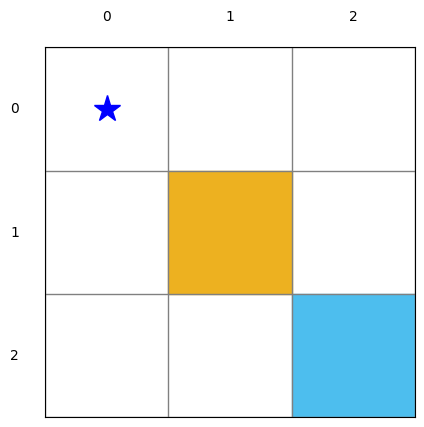

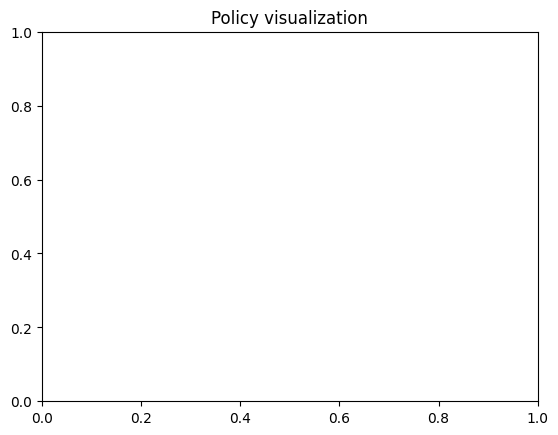

In [13]:
# 策略可视化示例
env_policy = GridWorld(
    env_size=(3, 3),
    start_state=(0, 0),
    target_state=(2, 2),
    forbidden_states=[(1, 1)]
)

state, _ = env_policy.reset()
env_policy.render()

# 创建一个简单的策略矩阵 (9个状态，5个动作)
# 策略：总是向右或向下移动
policy_matrix = np.zeros((9, 5))
for i in range(9):
    x = i % 3
    y = i // 3
    if (x, y) == (2, 2):  # 目标状态，选择 stay
        policy_matrix[i, 4] = 1.0
    elif (x, y) == (1, 1):  # 禁止状态
        policy_matrix[i, 4] = 1.0
    else:
        if x < 2:
            policy_matrix[i, 1] = 0.5  # 向右
        if y < 2:
            policy_matrix[i, 2] = 0.5  # 向下

env_policy.add_policy(policy_matrix)
plt.title("Policy visualization")
plt.show()

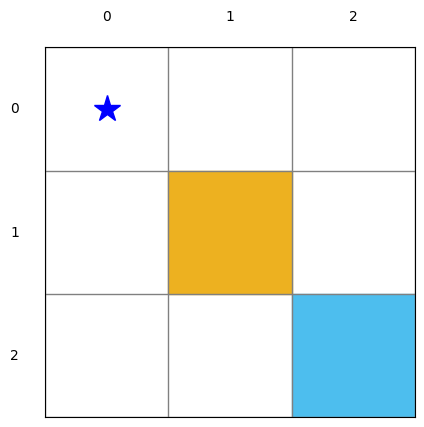

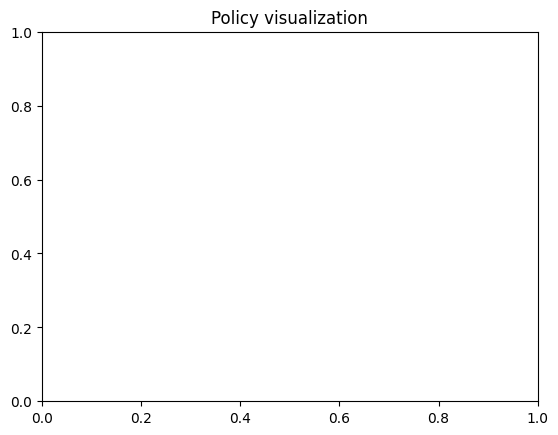

In [14]:
# 状态值可视化示例
env_values = GridWorld(
    env_size=(3, 3),
    start_state=(0, 0),
    target_state=(2, 2),
    forbidden_states=[(1, 1)]
)

state, _ = env_values.reset()
env_values.render()

# 创建示例状态值（例如：离目标越近值越大）
state_values = np.zeros(9)
for i in range(9):
    x = i % 3
    y = i // 3
    if (x, y) == (2, 2):  # 目标
        state_values[i] = 10.0
    elif (x, y) == (1, 1):  # 禁止状态
        state_values[i] = -5.0
    else:
        # 基于曼哈顿距离的简单值函数
        dist = abs(2 - x) + abs(2 - y)
        state_values[i] = 10.0 - dist * 2

env_values.add_state_values(state_values, precision=1)
plt.title("Policy visualization")
plt.show()

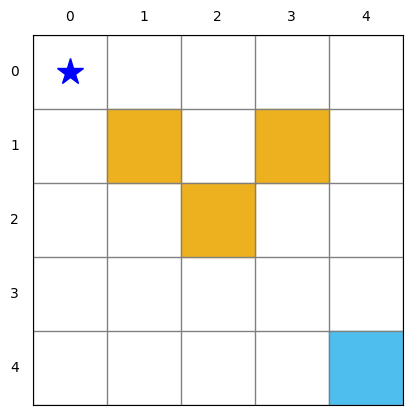

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [5]:
# 可视化示例
env_vis = GridWorld(
    env_size=(5, 5),
    start_state=(0, 0),
    target_state=(4, 4),
    forbidden_states=[(1, 1), (2, 2), (3, 1)]
)

# 执行一个简单的episode并可视化
state, _ = env_vis.reset()
env_vis.render()

# 简单的向目标移动
for _ in range(10):
    # 简单策略：交替向右和向下
    action = (1, 0) if np.random.rand() > 0.5 else (0, 1)
    state, reward, done, _ = env_vis.step(action)
    env_vis.render(animation_interval=0.3)
    if done:
        print("到达目标！")
        break